### Imports

In [19]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

### Data Settings

In [20]:
file_path = 'resources\Desktoppanel.csv'
data = pd.read_csv(file_path)

na_replacement = -9999

data['before_2013'] = data['epq8001'] - data['epq8902'] - data['epq8905']
temporary_workers = data['epq8002'].fillna(na_replacement) + data['epq8003'].fillna(na_replacement) + data['epq8004'].combine_first(data['before_2013']).fillna(na_replacement)

y = temporary_workers
X = data[['aq1001', 'aq1002', 'aq2001', 'aq2003', 'aq3003', 'mq1001']].fillna(na_replacement)
# 다수사업장 여부, 본사 여부, 조직유형, 상장 여부, 설립년도, 노조여부 

# print(X.head(100))
# print(y.head(100))

model = sm.OLS(y, X).fit().get_robustcov_results()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 03 Jun 2024   Prob (F-statistic):                nan
Time:                        20:02:44   Log-Likelihood:            -3.0476e+05
No. Observations:               20592   AIC:                         6.095e+05
Df Residuals:                   20586   BIC:                         6.096e+05
Df Model:                           5                                         
Covariance Type:                  HC1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
aq1001     -5.337e+06   3.32e+05    -16.088      0.0

### Visualization

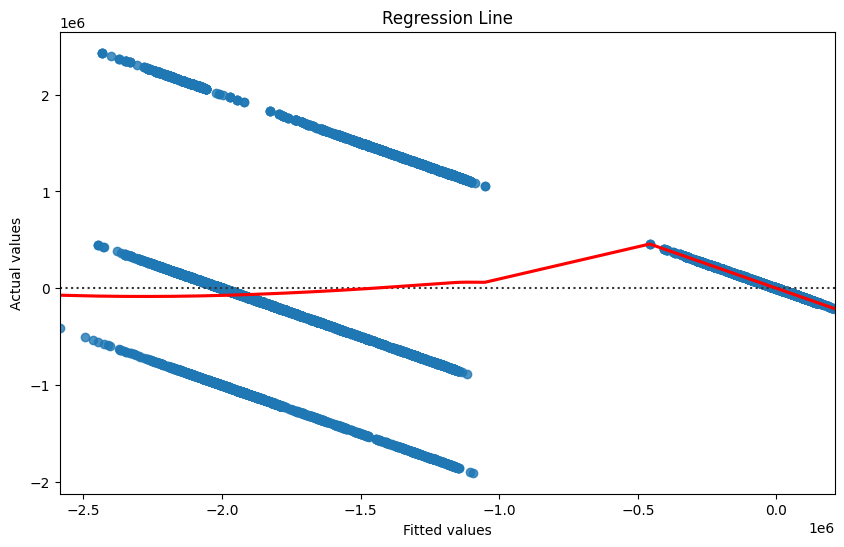

In [22]:
plt.figure(figsize=(10, 6))
sns.residplot(x=model.fittedvalues, y=y, lowess=True, line_kws={"color": "red"})
plt.xlabel('Fitted values')
plt.ylabel('Actual values')
plt.title('Regression Line')
plt.show()